In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Useful metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix

## Neural Network

### Layers
We define the neural network model as series of layers, with forward and backpropagation functions. The forward function takes an input $x$ of size *batch_size $\times$ input_dim*, and backward function takes the upstream gradient. A multi-layer perceptron will have layers of three types:
- **FullyConnected:** The main layer that performs the transformation $xW + B$
- **ReLU:** The activation layer that applies the ReLU function $max(0,x)$
- **SoftmaxCrossEntropy:** The final layer that computes Softmax and Cross Entropy loss

### Dummy Layer
We first define a dummy Layer class. Each specific layer will be an instance of this class.
- **Forward:** Just returns the input $x$
- **Backward:** Returns the upstream gradient 

In [3]:
class Layer():
    def __init__(self):
        pass

    def forward(self, x):
        return x
    
    def backward(self, x, up_grad):
        idt_mat = np.eye(x.shape[1])
        return np.dot(up_grad, idt_mat)

### Fully Connected
The fully connected layer will have input dimensions, output dimensions and learning rate as parameters. 
It randomly initializes the weights and, bias with zeroes.
- **Forward:** Returns the transformation $xW+B$
- **Backward:** Returns the gradient of input $dx$, and updates $W$ and $B$

In [4]:
class FullyConnected(Layer):
    def __init__(self, in_dim, out_dim, lr=1.0):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr

        np.random.seed(42)
        self.weights = 1e-2 * np.random.randn(in_dim,out_dim)
        self.bias = np.zeros(out_dim)
    
    def forward(self, x):
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, x, up_grad):
        dx = np.dot(up_grad, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        dW = np.dot(x.T, up_grad)
        #print('dW:', dW)
        db = up_grad.mean(axis=0) * x.shape[0]
        #print('dbias:', db)
        
        assert dW.shape == self.weights.shape and db.shape == self.bias.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.lr * dW
        self.bias = self.bias - self.lr * db
        
        return dx


### ReLU
The relu layer will have no parameters, since it only performs the $max$ function. 
- **Forward:** Returns the transformation $max(0,x)$
- **Backward:** Returns the gradient of input $dx$ if $x>0$

In [5]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return np.maximum(0, x)
    
    def backward(self, x, up_grad):
        relu_grad = x > 0
        return up_grad * relu_grad

### Softmax and Cross Entropy (SCE)
The SCE layer will have no parameters, but will contain the function $softmax$ to calculate softmax values, $s$. 
The functions also take the labels $Y$ as an argument.
- **Forward:** Returns the cross entropy loss
- **Backward:** Returns the softmax cross entropy loss equal to $s-y$

In [6]:
class SoftmaxCrossEntropy(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y_true):
        smax = self.softmax(x)
        #print(smax)
        m = y_true.shape[0]
        
        log_likelihood = -np.log(smax[range(m), y_true])
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, x, y_true):
        m = y_true.shape[0]
        grad = self.softmax(x)
        grad[range(m),y_true] -= 1
        grad = grad/m
        return grad
    
    def softmax(self, x):
        # x: (batch_size X 10)
        # y: (batch_size X 1)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### Data

(-1.0, 1.0)

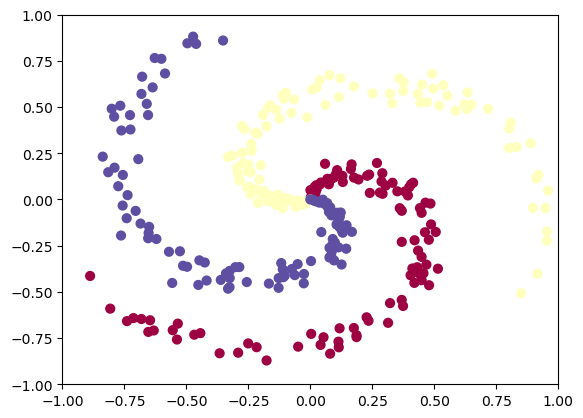

In [7]:
np.random.seed(0)
N=100
D=2
K=3
X=np.zeros((N*K,D))
Y=np.zeros(N*K,dtype='uint8')
for j in range(K):
    ix=range(N*j,N*(j+1))
    r=np.linspace(0.0,1,N)
    t=np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2
    X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    Y[ix]=j
fig=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,s=40,cmap=plt.cm.Spectral)
plt.ylim([-1,1])
plt.xlim([-1,1])

### Model
Let us define the model as a list of layers starting with the input layer and ending with SCE layer.

In [15]:
model = []
model.append(FullyConnected(2,100))
model.append(ReLU())
model.append(FullyConnected(100,3))
model.append(SoftmaxCrossEntropy())

# Storing the model size without the loss layer
model_size = len(model) - 1
print(f"Model Size: {model_size}")

Model Size: 3


In [16]:
# Weights and biases
print(f"W_1: {model[0].weights.shape}")
print(f"B_1: {model[0].bias.shape}\n")

print(f"W_2: {model[2].weights.shape}")
print(f"B_2: {model[2].bias.shape}\n")

W_1: (2, 100)
B_1: (100,)

W_2: (100, 3)
B_2: (3,)



### Training Loop
Let us define a training loop that will run forward then backward for one step


In [24]:
def train_loop(model, x, Y):
    model_size = len(model)-1

    # Forward prop
    out = [x]
    for i in range(model_size):
        out.append(model[i].forward(out[-1]))
    loss = model[-1].forward(out[-1],Y)

    # Backprop
    upgrad = [model[-1].backward(out[-1], Y)]
    for i in reversed(range(model_size)):
        upgrad.append(model[i].backward(out[i], upgrad[-1]))
    
    return loss

In [25]:
def predict(model, x, Y):
    model_size = len(model)-1

    # Forward prop
    out = [x]
    for i in range(model_size):
        out.append(model[i].forward(out[-1]))
    loss = model[-1].forward(out[-1],Y)

    return out[-1].argmax(axis=-1), loss

In [26]:
from tqdm import trange
def iterate_minibatches(x, Y, batch_size, shuffle=False):
    assert len(x) == len(Y)
    if shuffle:
        indices = np.random.permutation(len(x))
    for start_idx in trange(0, len(x) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield x[excerpt], Y[excerpt]

### Training

In [27]:
train_log = []

for epoch in range(10000):
    '''
    for x_batch,y_batch in iterate_minibatches(X, Y ,batch_size=300):
        train_loop(model, x_batch, y_batch)
    '''
    train_loop(model, X, Y)
    if epoch%1000==0:
        pred, loss = predict(model, X, Y)
        train_log.append(np.mean(pred==Y))
        
        print(f"Epoch: {epoch}")
        print(f"Train accuracy: {train_log[-1]}")
        print(f"Loss: {loss}")
    #plt.plot(train_log,label='train accuracy')
    #plt.legend(loc='best')
    #plt.grid()
    #plt.show()

Epoch: 0
Train accuracy: 0.55
Loss: 1.0983201190485516
Epoch: 1000
Train accuracy: 0.9366666666666666
Loss: 0.1454799898003607
Epoch: 2000
Train accuracy: 0.9933333333333333
Loss: 0.0467080178539611
Epoch: 3000
Train accuracy: 0.9933333333333333
Loss: 0.03443310506712663
Epoch: 4000
Train accuracy: 0.9933333333333333
Loss: 0.028989340324389944
Epoch: 5000
Train accuracy: 0.9933333333333333
Loss: 0.0257761700184746
Epoch: 6000
Train accuracy: 0.9933333333333333
Loss: 0.023619935637944692
Epoch: 7000
Train accuracy: 0.9933333333333333
Loss: 0.022067175898494006
Epoch: 8000
Train accuracy: 0.9933333333333333
Loss: 0.02087573301379725
Epoch: 9000
Train accuracy: 0.9933333333333333
Loss: 0.019912700783666783


In [22]:
f1 = FullyConnected(2,100)
relu = ReLU()
f2 = FullyConnected(100,3)
sce = SoftmaxCrossEntropy()

out1 = f1.forward(X)
out2 = relu.forward(out1)
out3 = f2.forward(out2)
loss = sce.forward(out3, Y)
print(loss)

upgrad = sce.backward(out3, Y)
f2_grad = f2.backward(out2, upgrad)
relu_grad = relu.backward(out1, f2_grad)
f1_grad = f1.backward(X, relu_grad)

out1 = f1.forward(X)
out2 = relu.forward(out1)
out3 = f2.forward(out2)
loss = sce.forward(out3, Y)
print(loss)

1.0985949762209464
1.0983201190485516


In [23]:
f1 = FullyConnected(2,100)
relu = ReLU()
f2 = FullyConnected(100,3)
sce = SoftmaxCrossEntropy()

losses = []
for i in range(10000):
    # Forward
    out1 = f1.forward(X)
    out2 = relu.forward(out1)
    out3 = f2.forward(out2)
    loss = sce.forward(out3, Y)

    losses.append(loss)

    # Backprop
    upgrad = sce.backward(out3, Y)
    f2_grad = f2.backward(out2, upgrad)
    relu_grad = relu.backward(out1, f2_grad)
    f1_grad = f1.backward(X, relu_grad)

    if i%1000==0:
        print(f"iteration {i}: loss {loss:.5f}")

iteration 0: loss 1.09859
iteration 1000: loss 0.14848
iteration 2000: loss 0.04673
iteration 3000: loss 0.03444
iteration 4000: loss 0.02899
iteration 5000: loss 0.02578
iteration 6000: loss 0.02362
iteration 7000: loss 0.02207
iteration 8000: loss 0.02088
iteration 9000: loss 0.01991


In [16]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

(-1.0, 1.0)

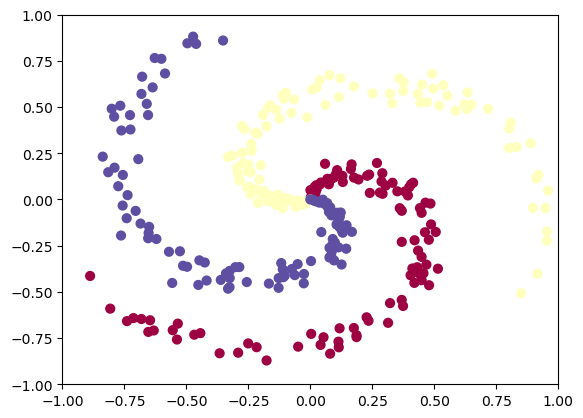

In [17]:
np.random.seed(0)
N=100
D=2
K=3
X=np.zeros((N*K,D))
Y=np.zeros(N*K,dtype='uint8')
for j in range(K):
  ix=range(N*j,N*(j+1))
  r=np.linspace(0.0,1,N)
  t=np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2
  X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
  Y[ix]=j
fig=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,s=40,cmap=plt.cm.Spectral)
plt.ylim([-1,1])
plt.xlim([-1,1])

In [18]:
print(X.shape)

(300, 2)


In [19]:
network = []
network.append(FullyConnected(X.shape[1],100))
network.append(ReLU())
network.append(FullyConnected(100,3))

def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
    
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

100%|██████████| 300/300 [00:00<00:00, 10359.46it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Epoch 0
Train accuracy: 0.3333333333333333


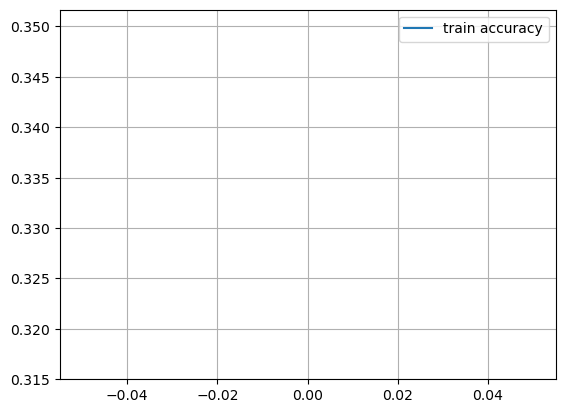

100%|██████████| 300/300 [00:00<00:00, 10605.42it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Epoch 1
Train accuracy: 0.3333333333333333


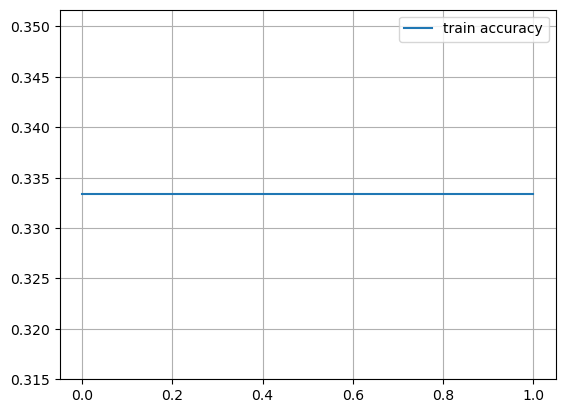

In [21]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

train_log = []

for epoch in range(2):
    for x_batch,y_batch in iterate_minibatches(X,Y,batchsize=1):
        train(network,x_batch,y_batch)
    pred = predict(network,X)
    print(pred)
    
    train_log.append(np.mean(pred==Y))
    
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()